In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 06a
### Neural Network with :
- Multiple hidden layers 
- ${Tanh}$ activation function
- multi-class

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20000 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg'

plt.rcParams.update(params)

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;color:blue;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [4]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

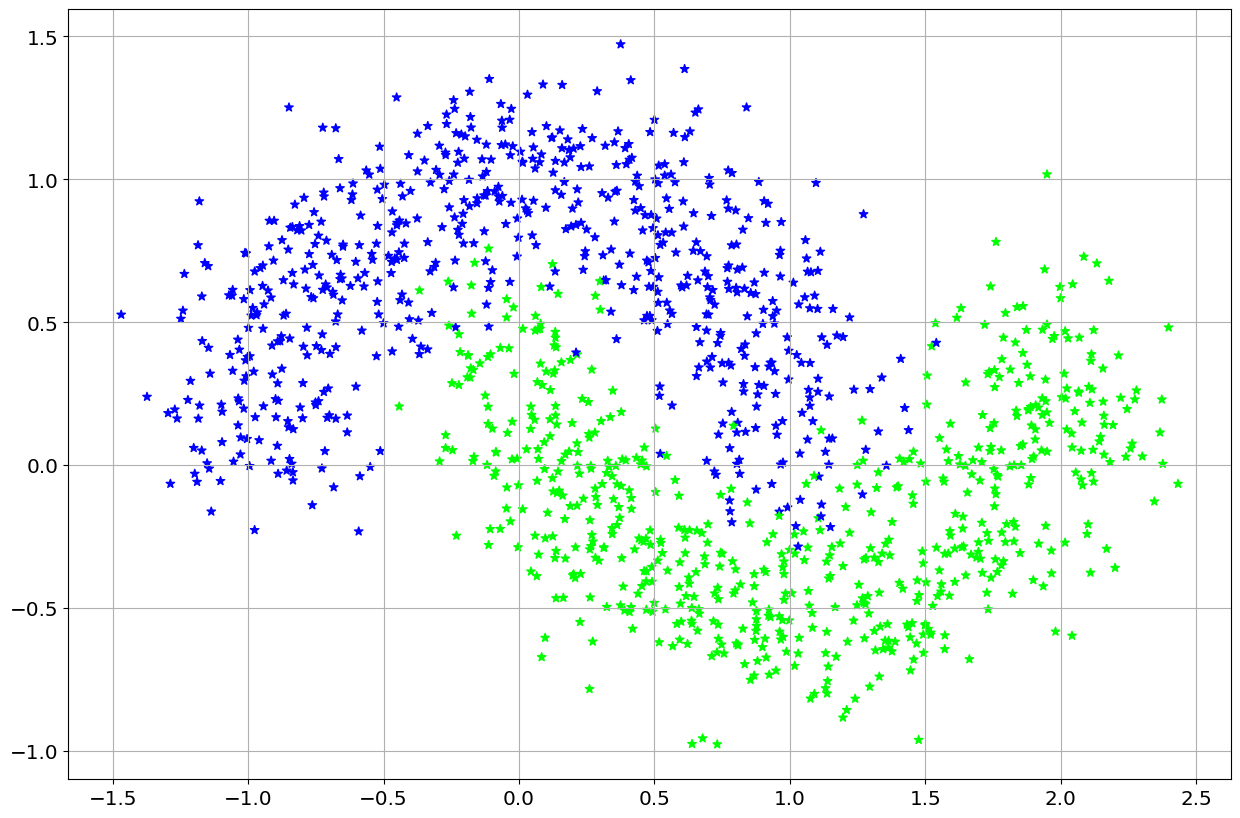

In [5]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

In [6]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Args:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    

    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])

    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], 
                c=np.argmax(y, axis=1), ### for multiclass data
                cmap=CMAP, 
                edgecolors='black')

In [7]:
################################
### Make it multiclass data
################################

y = pd.get_dummies(y).values
y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [8]:
y.shape

(1280, 2)

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='images/dnn_nb_s05_fig2.png' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


In [10]:
def fn_softmax(z):
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [11]:
sm = fn_softmax(np.asarray([[8, 5, 0]]))
print (sm, '\nTotal of all values', sm.sum())

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]] 
Total of all values 0.9999999999999999


In [12]:
sm = fn_softmax(np.asarray([[-10, 0., 10]]))
print (sm, '\nTotal of all values', sm.sum())

[[2.06106005e-09 4.53978686e-05 9.99954600e-01]] 
Total of all values 0.9999999999999999


### Other Activation Function
Keep tanh Function for hidden layer

In [13]:
def fn_activ(x):

    return np.tanh(x)

def fn_activ_prime(x):

    return 1.0 - np.tanh(x)**2

## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [20]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    W3, b3, W4, b4 = model['W3'], model['b3'], model['W4'], model['b4']
    W5, b5 = model['W5'], model['b5']
    
    # Layer 1
    z1 = X.dot(W1) + b1
    a1 = fn_activ(z1)  # Activation function

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_activ(z2)  # Activation function

    # Layer 3
    z3 = a2.dot(W3) + b3
    a3 = fn_activ(z3)  # Activation function

    # Layer 4
    z4 = a3.dot(W4) + b4
    a4 = fn_activ(z4)  # Activation function

    # Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5) # Activation function

    # Calculating the loss
    data_loss = -(y * np.log(a5) + (1 - y) * np.log(1 - a5)).sum() 

    return 1./num_examples * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation.

In [15]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    W3, b3, W4, b4 = model['W3'], model['b3'], model['W4'], model['b4']
    W5, b5 = model['W5'], model['b5']
    
    # Layer 1
    z1 = X.dot(W1) + b1
    a1 = fn_activ(z1)  # Activation function

    # Layer 2
    z2 = a1.dot(W2) + b2
    a2 = fn_activ(z2)  # Activation function

    # Layer 3
    z3 = a2.dot(W3) + b3
    a3 = fn_activ(z3)  # Activation function

    # Layer 4
    z4 = a3.dot(W4) + b4
    a4 = fn_activ(z4)  # Activation function

    # Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5) # Activation function
    
    return np.argmax(a5, axis =1) # pick with one with highest probabilities

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Prepare Model:

In [16]:
def build_model(param, X, y, 
                epochs = EPOCHS, 
                alpha = ALPHA,
                print_loss=False):
    
    '''
    Args:
        param : Dictionary with key 'nn_hdim' specifying number of nodes in a layer
        X : Training features to train
        y : Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    
    # Initialize the parameters to random values. We need to learn these.

    # Layer 1
    W1 = np.random.rand(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    
    # Layer 2
    W2 = np.random.rand(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    

    # Layer 3
    W3 = np.random.rand(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    
    # Layer 4
    W4 = np.random.rand(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
    
    
    # Layer 5
    W5 = np.random.rand(param['nn_hdim'][4], nn_output_dim) / np.sqrt(np.sqrt(param['nn_hdim'][4]))
    b5 = np.zeros((1, nn_output_dim))
    
    curr_loss = 0
    loss = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        a1 = fn_activ(z1)  # Activation function
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        a2 = fn_activ(z2)  # Activation function
        
        # Layer 3
        z3 = a2.dot(W3) + b3
        a3 = fn_activ(z3)  # Activation function
        
        # Layer 4
        z4 = a3.dot(W4) + b4
        a4 = fn_activ(z4)  # Activation function
       
        # Layer 5
        z5 = a4.dot(W5) + b5
        a5 = fn_softmax(z5) # Activation function

        #######################
        #   Back propagation  #
        #######################
        # Layer 5
        dz5 = a5 - y
        
        dW5 = (a4.T).dot(dz5)
        assert(W5.shape == dW5.shape), 'Shape of W5 {} and dW5 {} do not match'.format(W5.shape, dW5.shape)
        
        db5 = np.sum(dz5, axis=0, keepdims=True) 
        assert(b5.shape == db5.shape), 'Shape of b5 {} and db5 {} do not match'.format(b5.shape, db5.shape)
        
        da4 = dz5.dot(W5.T)
        
        #Layer 4
        dz4 = da4* fn_activ_prime(a4)
        
        dW4 = (a3.T).dot(dz4)
        assert(W4.shape == dW4.shape), 'Shape of W4 {} and dW4 {} do not match'.format(W4.shape, dW4.shape)
        
        db4 = np.sum(dz4, axis=0, keepdims=True) 
        assert(b4.shape == db4.shape), 'Shape of b4 {} and db4 {} do not match'.format(b4.shape, db4.shape)
        
        da3 = dz4.dot(W4.T)
        
        #Layer 3
        dz3 = da3* fn_activ_prime(a3)
        
        dW3 = (a2.T).dot(dz3)
        assert(W3.shape == dW3.shape), 'Shape of W3 {} and dW3 {} do not match'.format(W3.shape, dW3.shape)
        
        db3 = np.sum(dz3, axis=0, keepdims=True) 
        assert(b3.shape == db3.shape), 'Shape of b3 {} and db3 {} do not match'.format(b3.shape, db3.shape)
        
        da2 = dz3.dot(W3.T)
        
        #Layer 2
        dz2 = da2* fn_activ_prime(a2)
        
        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) 
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
        
        da1 = dz2.dot(W2.T)
       
        
        # Layer 1
        dz1 = da1* fn_activ_prime(a1)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/num_examples
        b1 += -alpha * db1/num_examples
        
        W2 += -alpha * dW2/num_examples
        b2 += -alpha * db2/num_examples
        
        W3 += -alpha * dW3/num_examples
        b3 += -alpha * db3/num_examples

        W4 += -alpha * dW4/num_examples
        b4 += -alpha * db4/num_examples
        
        W5 += -alpha * dW5/num_examples
        b5 += -alpha * db5/num_examples

        #  Model as a Dict object to be return.
        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 
                 'W2': W2, 'b2': b2,
                 'W3': W3, 'b3': b3,
                 'W4': W4, 'b4': b4,
                 'W5': W5, 'b5': b5}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, curr_loss))
    loss_hist['loss'] = loss        
    loss_hist['epoch'] = epoch        
    
    return model

In [17]:
num_examples = len(X_train) # training set size
nn_output_dim = y_train.shape[1] # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}

In [18]:
layer_param = {}

layer_param['nn_hdim'] = [X_train.shape[1], 5, 5, 4, 3]

In [21]:
# Build a model with a multiple hidden layers
model = build_model(layer_param, X_train, y_train,
                    epochs = EPOCHS, 
                    alpha = ALPHA, 
                    print_loss=True)

Loss after iteration 0: 0.000000
Loss after iteration 1000: 0.282541
Loss after iteration 2000: 0.164526
Loss after iteration 3000: 0.150309
Loss after iteration 4000: 0.162963
Loss after iteration 5000: 0.184250
Loss after iteration 6000: 0.143079
Loss after iteration 7000: 0.139834
Loss after iteration 8000: 0.252347
Loss after iteration 9000: 0.137024
Loss after iteration 10000: 0.137929
Loss after iteration 11000: 0.141674
Loss after iteration 12000: 0.133105
Loss after iteration 13000: 0.132586
Loss after iteration 14000: 0.133867
Loss after iteration 15000: 0.132117
Loss after iteration 16000: 0.131843
Loss after iteration 17000: 0.131414
Loss after iteration 18000: 0.130730
Loss after iteration 19000: 0.130431


In [22]:
model

{'W1': array([[-3.61231113, -1.44283787,  1.97499464,  0.99693235, -3.01462977],
        [ 0.77575813,  0.62562333,  0.88657206, -0.02150746,  0.66261909]]),
 'b1': array([[ 3.00182601,  1.5212623 , -1.03119736, -1.04269895, -0.68673471]]),
 'W2': array([[ 0.67981693, -0.19429602,  0.88072963,  0.70998549,  0.82498259],
        [-0.13415328, -0.20693889,  0.46182025,  0.5408502 ,  1.20773825],
        [ 1.53908117,  2.54112828,  1.21234725,  1.60416126,  1.84381901],
        [-0.08697488,  0.19852698,  0.05531226, -0.2238607 , -0.8086538 ],
        [ 1.58083414,  0.70757288,  0.7685308 ,  0.96160306,  0.28637011]]),
 'b2': array([[-0.53040252,  0.31719765, -0.08792303, -0.02256198,  0.31812342]]),
 'W3': array([[0.44680341, 0.44922165, 1.26319991, 1.11515272],
        [0.90324838, 0.82920206, 0.78133262, 1.14107449],
        [0.57072991, 0.37121405, 0.67683458, 0.52194658],
        [0.67951947, 0.46693683, 0.57446276, 0.72463415],
        [1.2955544 , 1.24244843, 0.3969258 , 0.52519626

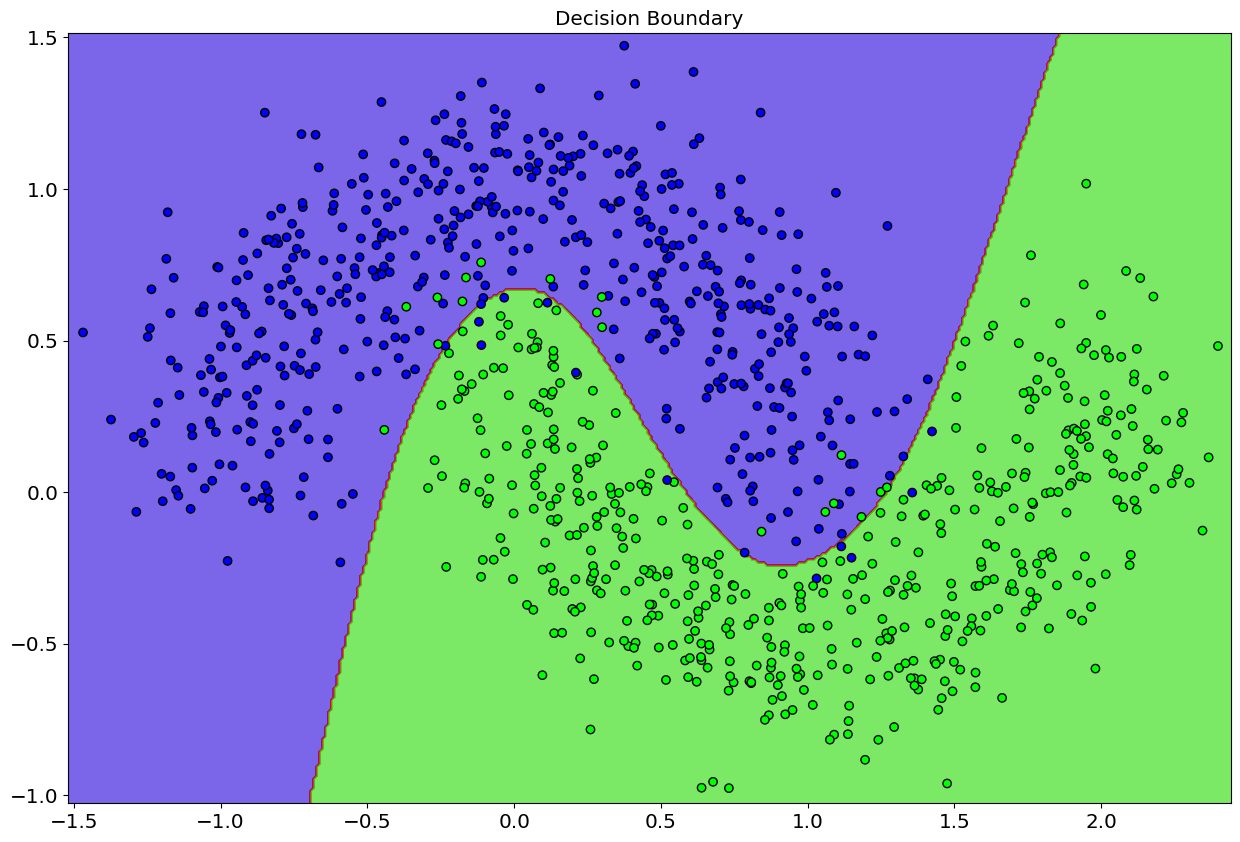

In [23]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

plt.title("Decision Boundary");

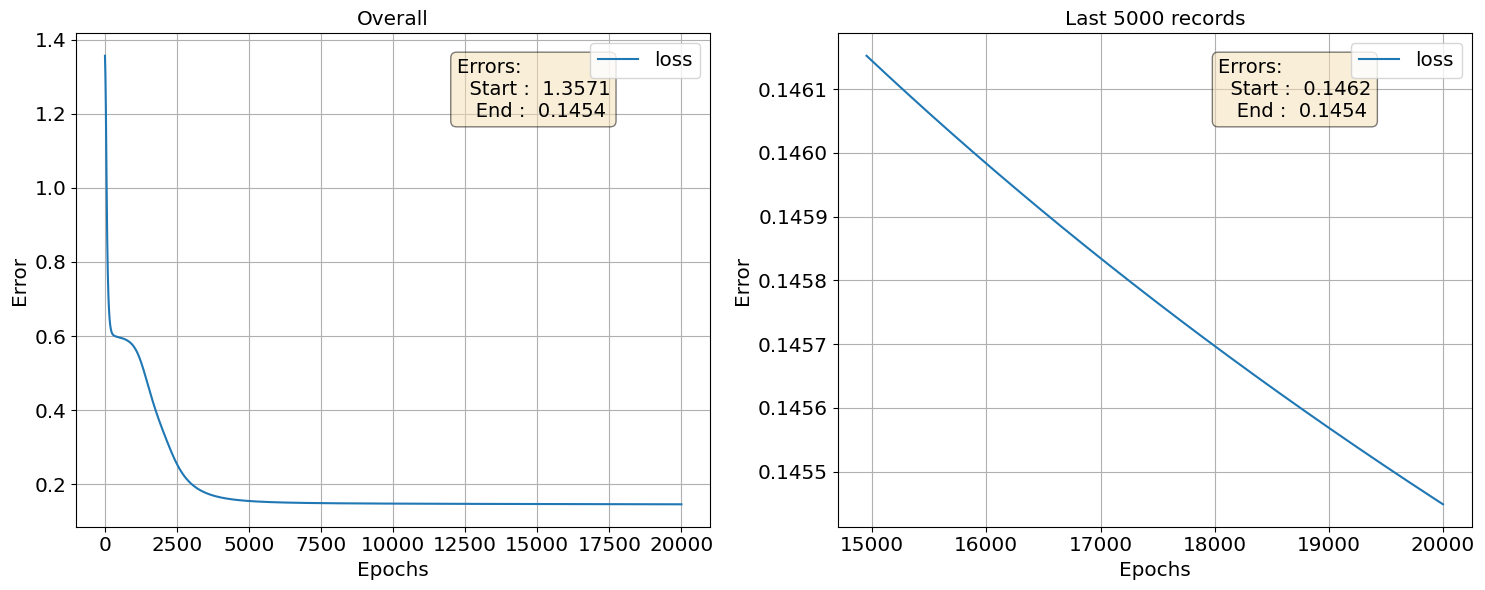

In [22]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 5000

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

### Would contest that we should have used higher epochs as loss is still coming down? How many epochs are sufficient?

In [23]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [24]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

Accuracy score on Train Data : 0.96875


In [25]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       522
           1       0.97      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



In [26]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.9609375


In [27]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.96      0.96      0.96       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



In [28]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[113,   5],
       [  5, 133]])

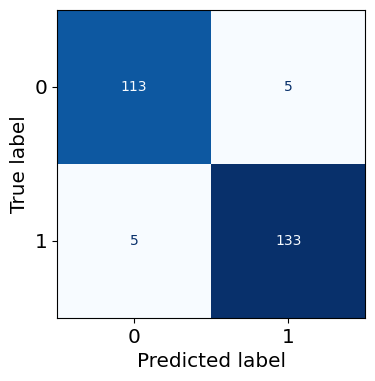

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();